# Predicting the US depression rate with Google Trends
## DIGITAL EPIDEMIOLOGY
## ASSIGNMENT 2

### Sergio Ballesteros and Michela Bragagnolo

The goal of this project is to create a model that predicts the prevalence of a specific chronic disease or health risk factor from digital records of online behavior. The chronic disease choosen in our case is depression.

### PART 1: Correlation study

### 1.1 - Study the correlation between the ground truth data and the Google Trends data. Explore multiple features of the ground truth data (e.g., crude prevalence, age-adjusted prevalence, etc.), and multiple keywords or entity types for querying the Google Trends data. Check for stability (or lack there of) across different years.

The *Ground Truth* data are provided by the Behavioral Risk Factor Surveillance System database of the US Center for Disease Control and Prevention (https://www.cdc.gov/brfss/). We selected the data concerning Depression for all the available years, 2011-2016, for each state of the Unites States.
In the Ground-Truth data we considered the age-adjusted prevalence and the crude prevalence.
The first feature *age-adjusted prevalence* is adjusted to remove the effect of a variable, in our case the age, to permit unbiased comparison between groups having different compositions with respect to that variable.
The *crude prevalence* refers to the total number of events occurring in an entire population over a period of time, without reference to any of the individuals or subgroups within the population. 



In [1]:
import matplotlib.pyplot as plt
import os
from scipy.signal import correlate
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn import linear_model
import matplotlib.pyplot as plt

In [3]:
# This are going to be the working paths
path_queries = "data/queries/"
path_ground_truth = "data/ground_truth/"
path_income = "data/income/"
path_poverty = "data/poverty_rate/"
path_health = "data/health/"
path_age = "data/median_age/"
path_fborn = "data/foreign_born/"
path_educ = "data/educ/"

To analyze the data we need to format the ground truth, which is in the folder "data/ground_truth/". 
This following function does so and saves the files under the respective paths
Also it removes the data about Virgin Islands since is incomplete.

In [4]:
def generate_time_series(prefix, path_ground_truth = "data/ground_truth/",
                         del_nan = False, sep = ","):
    '''
    Generates timeseries of each state from the ground truth
    :param prefix: prefux of the filename
    :param path_ground_truth: path to the folder where the files are
    :param del_nan: boolean, delete nan rows (only virgin islands has them)
    :param sep: "," or ";"
    :return: time series dataframe
    '''
    years = ["2011", "2012", "2013", "2014", "2015", "2016"]
    files = [path_ground_truth + prefix + year + ".csv" for year in years]
    list_df = []
    for i in range(len(files)):
        df = pd.read_csv(files[i], sep=sep)
        df = df[(df["LocationAbbr"] != "US") & (df["LocationAbbr"] != "UW")]
        df = df[["LocationDesc", "Data_Value"]].dropna()
        df = df.set_index("LocationDesc")
        list_df.append(df)
    df = pd.concat(list_df, axis=1)
    df.columns = years
    if del_nan == True:
        # Virgin islands have nan values, from 2011 to 2015, so we remove them
        df = df.dropna()
    return df

Create the time series of the states for the GT and save the to files in the working directories

In [5]:
df_timeseries_states_crude = generate_time_series(prefix="crude_", del_nan=True).transpose()
df_timeseries_states_crude.to_csv(path_ground_truth + "time_series_states_crude.csv")
df_timeseries_states_adjusted = generate_time_series(prefix="adjusted_", del_nan=True, sep=";").transpose()
df_timeseries_states_adjusted.to_csv(path_ground_truth + "time_series_states_adjusted.csv")

In [6]:
# This is the ground truth on each state each year
df_timeseries_states_adjusted

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2011,21.1,16.5,17.3,22.9,12.1,17.3,15.2,14.2,16.0,16.3,...,16.4,18.9,16.4,21.9,23.0,13.9,19.5,20.1,14.6,18.9
2012,21.6,16.6,18.8,22.2,11.5,17.1,16.6,14.6,16.3,17.0,...,15.3,19.6,15.3,20.8,22.2,16.5,22.2,20.9,16.1,17.8
2013,21.4,16.1,17.9,23.2,12.9,18.0,17.2,17.6,20.8,16.7,...,14.6,19.0,15.9,21.8,23.1,16.3,23.4,22.0,18.1,18.7
2014,21.1,15.4,18.7,21.5,13.1,16.9,18.2,18.3,18.1,15.9,...,17.0,21.2,14.5,20.7,22.1,17.4,21.4,23.8,16.9,19.0
2015,22.0,15.8,18.4,23.6,12.8,19.3,17.6,17.9,18.1,16.3,...,16.3,21.1,15.9,20.8,23.1,15.7,21.7,23.4,17.5,21.0
2016,21.9,14.1,16.7,23.9,13.3,18.5,15.9,16.7,16.6,14.2,...,15.9,21.1,12.4,21.4,23.0,16.0,21.0,24.1,16.9,15.8


The *digital proxy data* concern Google Trends data available at https://trends.google.com. The data are collected in a semi-automatically way using an R code (find in attach). We search hundreds of different words that should be correlated with the disease, taking inspiration on scientific papers, blogs related to depression, medical websites..

In [ ]:
# This is the R code
'''

words = c('victim', 'certify', 'statistics', 'misunderstanding', 'tragic', 'oppressed', 'solitary', 'paranoid', 'personal', 'insecure', 'counsel', 'tragedy', 'cruel', 'overcome', 'parents', 'suicidal', 'dreary', 'inability', 'fight', 'unique', 'joking', 'attention', 'disease', 'tearful', 'involvement', 'sugar', 'injured', 'monitor', 'happy', 'catatonic', 'prevent', 'interfere', 'fatigue', 'necessary', 'listening', 'talking', 'uncertain', 'unfulfilled', 'triumph', 'prevention', 'defensive', 'indicator', 'gloomy', 'broken', 'adolescents', 'shattered', 'empty', 'low', 'need', 'donut', 'anxiety', 'sorrow', 'progress', 'esteem', 'inactivity', 'blue', 'stigma', 'unhappy', 'hard work', 'studies', 'sad', 'fatigued', 'quality', 'love', 'melancholia', 'withdrawn', 'patience', 'crying', 'confide', 'security', 'die', 'blase', 'do i have depression', 'exhausted', 'insomnia', 'vulnerable', 'drugs', 'organize', 'sleep', 'melancholy', 'desperate', 'anxious', 'protect', 'fast food', 'awareness', 'death', 'opinion', 'suicide', 'rejected', 'health', 'breakdown', 'unusual', 'irritable', 'fear', 'disinterest', 'cycle', 'withdrawal', 'caregiver', 'inadequate', 'consumed', 'source', 'doctor', 'agency', 'wounded', 'education', 'concern', 'treat', 'abandoned', 'dreadful', 'problem', 'amenorrhea', 'miserable', 'weight loss', 'excluded', 'family', 'negative', 'prescription', 'effect', 'label', 'grouchy', 'troubled', 'distressed', 'world health organization', 'distractable', 'understanding', 'low sex drive', 'weak', 'morbid', 'cooperative', 'sport', 'mental health', 'dejected', 'inconsolable', 'nightmarish', 'freaking', 'mental', 'suffer', 'option', 'endure', 'diet', 'pessimism', 'poor', 'knowledgeable', 'resulting', 'confusion', 'tack', 'clarity', 'unhinged', 'lack', 'crisis', 'hurt', 'irritability', 'hot-line', 'quantity', 'antisocial', 'youth', 'lousy', 'weepy', 'time', 'guideline', 'abnormal', 'desolate', 'alone', 'lonely', 'agitated', 'unsettling', 'hopeless', 'sadness', 'kill', 'attitude', 'discrimination', 'hopelessness', 'cure', 'forlorn', 'warning', 'grief', 'conclude', 'programs', 'requirement', 'eat', 'bipolar', 'moody', 'oncoming', 'heal', 'distracted', 'brittle', 'anguish', 'immune', 'tentative', 'condition', 'succor', 'substance abuse', 'degree', 'progressive', 'self-conscious', 'signs', 'overwhelmed', 'pay attention', 'zero', 'fatalistic', 'devastated', 'suffering', 'exercise', 'knowledge', 'gain', 'woeful', 'patient', 'finality', 'isolation', 'jeer', 'quest', 'panic', 'review', 'debilitating', 'tired', 'trajectory', 'wretched', 'pills', 'touchy', 'medicine', 'defeated', 'uneasy', 'wailing', 'nervous', 'nothing', 'scared', 'anger', 'burger', 'sorrowful', 'achy', 'doomed', 'ability', 'improvement', 'treatment', 'worthless', 'thoughts', 'separation', 'psychiatrist', 'symptoms', 'detriment', 'evaluation', 'normal', 'watch', 'brain', 'appetite loss', 'bikini', 'thesis', 'sobbing', 'report', 'peers', 'upset', 'needy', 'abuse', 'interested', 'clinical', 'down', 'skills', 'irrational', 'cope', 'hereditary', 'all ages', 'disheartened', 'sympathetic', 'friends', 'level', 'antidepressant', 'communication', 'alarm', 'reality', 'medication', 'physician', 'pattern', 'disorder', 'worry', 'therapy', 'reckless', 'crushed', 'attempt', 'strength', 'fat', 'distraught', 'query', 'pizza', 'courage', 'despondent', 'pessimistic', 'data', 'issues', 'descent', 'depressed', 'isolated', 'teenagers', 'struggle', 'dismal', 'seriousness', 'siblings', 'depression', 'fragile', 'terrified', 'child', 'feelings', 'discontented', 'afraid', 'aid', 'validation', 'trapped', 'despair', 'help', 'pain', 'overeating', 'observation', 'grieving', 'uncomfortable', 'agony', 'unpredictable', 'affect', 'dog days', 'demoralized', 'media', 'talk', 'alienation', 'helpless', 'diagnosis')

library(gtrendsR)
# Years to download
year_2011 = "2011-01-01 2011-12-31"
year_2012 = "2012-01-01 2012-12-31"
year_2013 = "2013-01-01 2013-12-31"
year_2014 = "2014-01-01 2014-12-31"
year_2015 = "2015-01-01 2015-12-31"
year_2016 = "2016-01-01 2016-12-31"
year_all = "2011-01-01 2017-12-31"

years = c(year_2011, year_2012, year_2013, year_2014, year_2015, year_2016, year_all)
years_names = c("2011", "2012", "2013", "2014", "2015", "2016", "all")

# Download ans save to csv files
counter = 0
for(word in words){
  counter = counter + 1
  print(paste(counter, length(words), word))
  dir.create(word)
  for( i in c(1:length(years))){
    year = years[i]
    df = gtrends(word, time = year, geo = "US")
    write.csv2(df$interest_over_time, file = paste(word, "/", word, "_interest_over_time_", years_names[i], ".csv", sep = ""))
    write.csv2(df$interest_by_region, file = paste(word, "/", word, "_interest_by_region_", years_names[i], ".csv", sep = ""))
  }
}

print("Finished!")


'''

Now we transform the different datasets into suitable panda dataframes

In [7]:
# We are going to generate pandas dataframes with information about the GT and the queries
# but now per state
def generate_timeseries_querie_state(query, year, path_queries=path_queries):
    '''
    Creates the pandas timeseries of one querie
    :param query: str, querie like "depression"
    :param path_queries: str, path to all queries
    :return: dataframe of the time series
    '''
    df = pd.read_csv(path_queries + query + "/"
                     + query + "_" + "interest_by_region_" + year +".csv", sep=";")
    df = df[["location", "hits"]]
    df = df.set_index("location")
    
    df.columns = ["mean"]
    #df = df.transpose()
    return df


# Create a pandas DF of the queries and ground truth
# We store them in a dict: df_dict and each key is each year


queries = os.listdir(path_queries)
query_dict = {}
df_dict = {}

years = ["2011", "2012", "2013", "2014", "2015", "2016"]

for year in years:
    for query in queries:
        #print(query)
        df =  generate_timeseries_querie_state(query=query, year=year)
        df.columns = [query]
        query_dict[query] = df
    
    
    df = pd.concat([query_dict[q] for q in queries], axis=1)
    df = pd.concat([df_timeseries_states_adjusted.transpose()[year], df], axis=1)
    df.columns = list(["ground_truth_adjusted"]) + list(df.columns[1:])
    df = pd.concat([df_timeseries_states_crude.transpose()[year], df], axis=1)
    df.columns = list(["ground_truth_crude"]) + list(df.columns[1:])
    df = df.drop(["Guam", "Puerto Rico"])
    df = df.dropna(axis=1, how='any')
    df_dict[year] = df


# This is one example of the generated table, for 2011
df_dict["2011"].head()

,ground_truth_crude,ground_truth_adjusted,endless,victim,statistics,tragic,oppressed,solitary,paranoid,personal,...,observation,grieving,uncomfortable,stress,agony,affect,media,talk,alienation,diagnosis
Alabama,21.2,21.1,78.0,79.0,66.0,99.0,71.0,72.0,40.0,85.0,...,60.0,31.0,70.0,82.0,71.0,87.0,75.0,83.0,53.0,80.0
Alaska,16.5,16.5,80.0,48.0,72.0,46.0,65.0,33.0,43.0,75.0,...,69.0,61.0,74.0,71.0,100.0,71.0,61.0,43.0,41.0,47.0
Arizona,17.5,17.3,61.0,79.0,61.0,57.0,49.0,57.0,44.0,82.0,...,77.0,48.0,80.0,76.0,66.0,79.0,71.0,51.0,27.0,65.0
Arkansas,22.8,22.9,76.0,83.0,69.0,79.0,63.0,58.0,48.0,94.0,...,91.0,47.0,63.0,75.0,77.0,81.0,72.0,82.0,48.0,81.0
California,12.3,12.1,83.0,73.0,57.0,60.0,68.0,65.0,43.0,79.0,...,56.0,31.0,69.0,68.0,68.0,71.0,82.0,51.0,38.0,50.0


We are creating now a dataframe with all the features of the google trends and the data about ground truth for each state and each year considered. We added also some features useful for the next steps as described below. This dataframe will later be decomposed into the response vector and the matrix of covariates

The data used in this project from that point on are provided by the US Census Bureau. 
More specifically they are based on the American Community Survey (ACS), which is an ongoing survey that provides vital information on a yearly basis about United States and its people. All the data are collected for different years, from 2011 to 2016, for each state of US and are available on this link: https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml.

The data about the poverty concern the 'PERCENT OF PEOPLE BELOW POVERTY LEVEL IN THE PAST 12 MONTHS (FOR WHOM POVERTY STATUS IS DETERMINED'.
The income refers to 'MEDIAN HOUSEHOLD INCOME (INFLATION-ADJUSTED DOLLARS)'.
About the education we considered the 'PERCENT OF PEOPLE 25 YEARS AND OVER WHO HAVE COMPLETED HIGH SCHOOL (INCLUDES EQUIVALENCY)'.
For the health insurance coverage the data concern the 'PERCENT WITHOUT HEALTH INSURANCE COVERAGE'.
To know something more about the population we used also 'MEDIAN AGE OF THE TOTAL POPULATION'.

In [8]:
# Now we are going to add more features from the resources using the following structure
def load_csv_feature(path):
    df = pd.read_csv(path)
    df.columns = ["Year"] + list(df.columns)[1:]
    df["Year"] = [str(i) for i in df["Year"].values]
    df = df.set_index("Year").transpose()
    return df

In [9]:
# Put here the features to add to the matrix df_dict
df_health = load_csv_feature(path_health + "time_series_states_health.csv")
df_age = load_csv_feature(path_age + "time_series_states_age.csv")
df_fborn = load_csv_feature(path_fborn + "time_series_states_fborn.csv")
df_edu = load_csv_feature(path_educ + "time_series_states_edu.csv")

df_income = load_csv_feature(path_income + "time_series_states_income.csv")
df_poverty = load_csv_feature(path_poverty + "time_series_states_poverty.csv")


add_to_df = [df_income, df_poverty, df_health, df_fborn, df_age, df_edu]
names = ["income (real)", "poverty (real)", "health (real)", "foreign born  (real)", "median age (real)", "education (real)"]


# Add them to the df_dict
for year in years:
    df_dict[year] = pd.concat([df_dict[year]] + [add_to_df[i][year].rename(names[i]) for i in range(len(add_to_df))], axis=1)
    df_dict[year] = df_dict[year].drop(["Puerto Rico"])

We can now see the correlations of the queries and the ground truth for each year. We use the adjusted data for the plots but actually there is little difference if the correlation is made with the crude data. Each bar represents a single query, but the labels have been hiden for visualization purposes. Also the first two bars reaching almost correlation one are the ground truth themselfs.

We create a function to select the queries with most correlation
The queries selected will be the ones with a correlation to the ground truth higher than 0.1. That leads to 274 queries. We selected such a low correlation because when we make a linear model we will use the variables with higher coefficient, and remove the rest.

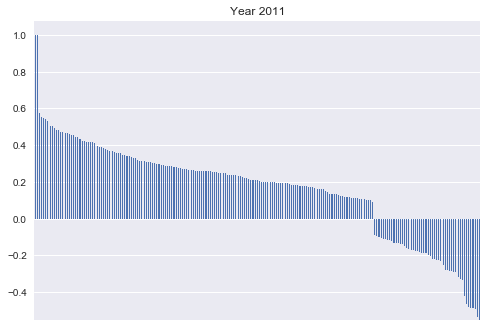

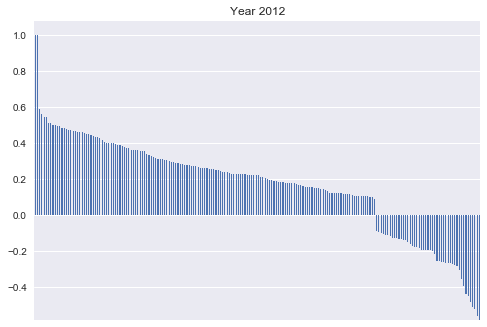

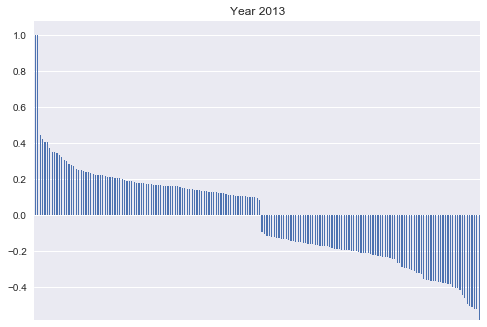

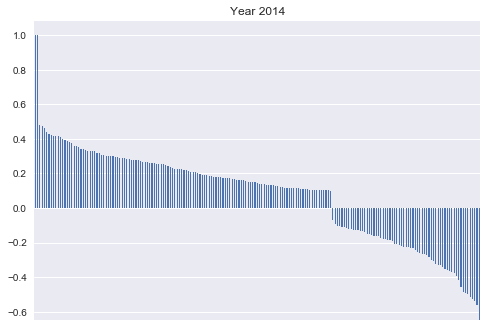

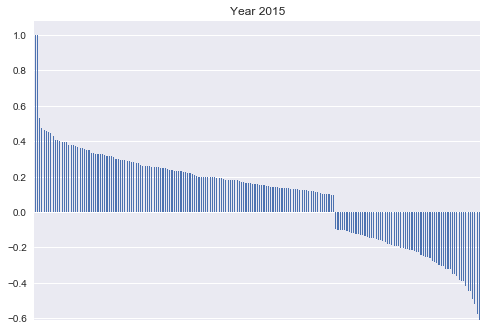

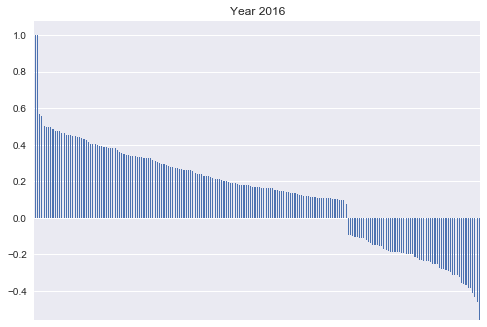

In [12]:
def get_correlated_queries(df, t=0.1, year = "", plot=True, names=""):
    corr_states = df.corr()
    corr = corr_states[(np.abs(corr_states["ground_truth_crude"]) > t) | (np.abs(corr_states["ground_truth_adjusted"]) > t) ]
    corr = corr[corr.index]
    if plot == True:
        corr["ground_truth_adjusted"].sort_values(ascending=False).plot(kind='bar')
        plt.title("Year " +  year)
        ax1 = plt.axes()
        x_axis = ax1.axes.get_xaxis()
        x_axis.set_visible(False)
        plt.show()
    '''
        print("Corr poverty - adjusted", np.corrcoef(df["ground_truth_adjusted"].values, df["poverty (real)"].values)[1,0])
        print("Corr poverty - crude", np.corrcoef(df["ground_truth_crude"].values, df["poverty (real)"].values)[1,0])
        print("Corr income - adjusted", np.corrcoef(df["ground_truth_adjusted"].values, df["income (real)"].values)[1,0])
        print("Corr income - crude", np.corrcoef(df["ground_truth_crude"].values, df["income (real)"].values)[1,0])
    
    for name in names:
        print()
        print(name)
        print(np.corrcoef(df["ground_truth_adjusted"].values, df[name].values)[1,0])
    '''
    return list(corr.index)

all_correlated_queries = []

for year in years:
    all_correlated_queries += get_correlated_queries(df_dict[year], year=year, plot=True, names=names)

all_correlated_queries = list(set(all_correlated_queries))

Studying the correlation between the ground truth and the Google trends data we found that the correlations were almost the same with respect to the ground truth adjusted and the ground truth crude, so for simplicity we plot just the adjusted results.
As we can see from 2013 we can notice more negative correlations, so it seems that there are some changes among years.

Below we print the top 8 correlations for each year:

In [19]:
# Find top queries
for year in years:
    df = df_dict[year]
    corr = df.corr()[(np.abs(df.corr()["ground_truth_crude"]) > 0.1) | (np.abs(df.corr()["ground_truth_adjusted"]) > 0.1) ]
    corr = corr[corr.index]
    print("Top correlations for year", year)
    print(corr["ground_truth_adjusted"].sort_values(ascending=False)[2:10])
    print()
    print("--------------------")
    print()

Top correlations for year 2011
fatigue       0.577410
pattern       0.551184
agony         0.550332
therapy       0.540098
death         0.531531
zero          0.507031
depression    0.502459
crushed       0.495777
Name: ground_truth_adjusted, dtype: float64

--------------------

Top correlations for year 2012
prescription    0.589559
fatigue         0.561927
low             0.544860
death           0.543174
achy            0.511512
diet            0.508661
depression      0.502141
down            0.497768
Name: ground_truth_adjusted, dtype: float64

--------------------

Top correlations for year 2013
mental            0.447754
tack              0.424318
achy              0.407384
mental health     0.404272
antidepressant    0.373938
grief             0.352280
pattern           0.350338
disorder          0.347622
Name: ground_truth_adjusted, dtype: float64

--------------------

Top correlations for year 2014
bipolar      0.482244
achy         0.471892
disorder     0.459842
abandoned

 ### 1.2 - Download US state-level data on income and poverty from the US Census Bureau. The data is available at: https://www.census.gov/data/tables/2017/demo/income-poverty/p60-259.html  Study the correlation of your target ground truth feature with income/poverty features.

Since the data available on this website was not enough we used the data mentioned before and we extended the computation of the correlation to some extra features such as health, median age, education and foreign born. The final dataframe is the one below:

In [22]:
# Now we create the big table and add categorical variables such as the year and the state

# First we map the state to a number
counter = 0
state_to_number = {}
for state in list(df_dict["2011"].index):
    state_to_number[state] = counter
    counter += 1
df_states = pd.DataFrame(state_to_number, index=["State ID"]).transpose()


# And finally we put together all the tables to make after the model
tmp_df = []
for year in years:
    df_year = df_states * 0 + int(year)
    df_year.columns = ["Year"]
    tmp_df.append(pd.concat([df_states, df_year, df_dict[year][list(all_correlated_queries)]], axis=1))
    
final_df = pd.concat(tmp_df).reset_index(drop=True)
final_df.head(10)

,State ID,Year,confused,feelings,nervous,triumph,vulnerable,statistics,thoughts,attitude,...,strength,depression,sympathetic,study,paranoid,level,melancholy,isolated,miserable,prevention
0,0,2011,63.0,68.0,85.0,59.0,55.0,66.0,74.0,83.0,...,85.0,79.0,71.0,70.0,40.0,76.0,73.0,70.0,81.0,68.0
1,1,2011,37.0,58.0,70.0,66.0,66.0,72.0,77.0,78.0,...,71.0,70.0,40.0,47.0,43.0,79.0,70.0,48.0,57.0,100.0
2,2,2011,56.0,59.0,77.0,57.0,68.0,61.0,69.0,77.0,...,66.0,73.0,55.0,54.0,44.0,73.0,73.0,52.0,75.0,65.0
3,3,2011,63.0,63.0,82.0,72.0,67.0,69.0,68.0,69.0,...,72.0,83.0,68.0,61.0,48.0,87.0,63.0,70.0,77.0,72.0
4,4,2011,54.0,71.0,72.0,68.0,75.0,57.0,63.0,65.0,...,59.0,66.0,48.0,45.0,43.0,67.0,87.0,50.0,77.0,57.0
5,5,2011,53.0,55.0,71.0,67.0,52.0,64.0,67.0,73.0,...,69.0,72.0,48.0,45.0,36.0,75.0,69.0,52.0,65.0,62.0
6,6,2011,61.0,73.0,85.0,60.0,67.0,72.0,66.0,55.0,...,76.0,83.0,61.0,59.0,47.0,73.0,71.0,69.0,89.0,66.0
7,7,2011,69.0,79.0,78.0,66.0,71.0,93.0,88.0,70.0,...,83.0,82.0,34.0,63.0,49.0,80.0,78.0,100.0,88.0,81.0
8,8,2011,51.0,53.0,55.0,56.0,76.0,66.0,56.0,58.0,...,61.0,58.0,40.0,51.0,35.0,60.0,57.0,42.0,64.0,86.0
9,9,2011,55.0,77.0,82.0,54.0,70.0,60.0,67.0,71.0,...,65.0,66.0,56.0,47.0,43.0,71.0,69.0,56.0,77.0,58.0


Below we can see the total correlations of the data taken from surveys with ground truth adjusted and ground truth crude.
The difference between values of the two ground truth indicators is minimum and the two more correlated variables (in absolute value) are foreign born and income, while education and health have little correlation

In [23]:
# The correlations are the following
final_df.corr()["ground_truth_adjusted"][names]

income (real)          -0.425442
poverty (real)          0.241381
health (real)          -0.053876
foreign born  (real)   -0.562338
median age (real)       0.263700
education (real)        0.054941
Name: ground_truth_adjusted, dtype: float64

In [24]:
# The correlations are the following
final_df.corr()["ground_truth_crude"][names]

income (real)          -0.442909
poverty (real)          0.270093
health (real)          -0.021784
foreign born  (real)   -0.555795
median age (real)       0.239338
education (real)        0.024557
Name: ground_truth_crude, dtype: float64

Here we can see the total correlations with ground truth adjusted and ground truth crude and also with other features, such as income and poverty but also with health, foreign born, median age and education.
The difference between values of the two ground truth indicators is minimum and the two more correlated variables are foreign born and income, while education and health have little correlation

### PART 2: Prediction model

### 2.1 - Set up a regression model that predicts your chosen ground truth indicator(s) on the basis of  Google Trends data for several keywords. Discuss the strategy you use for selecting additional keywords and for selecting which ones you include in the model. Select the model via temporal and spatial cross-validation, and discuss its generalizability across states and years on the basis of your results.

In [25]:
# Create the matrices of target and covariates
y = final_df["ground_truth_adjusted"].values  #Target
X = final_df[[col for col in final_df.columns if "ground_truth" not in col]]

# Export the data to work outside this jupyter file
X.to_csv("data/X.csv", index=False)
final_df["ground_truth_crude"].to_csv("data/y_crude.csv", index=False)
final_df["ground_truth_adjusted"].to_csv("data/y_adjusted.csv", index=False)

In [191]:
# Here we write a few functions that will be useful to perform the crossvalidation

def generate_indices(y, test_frac = 0.2):
    '''
    Generates "test_frac" random indices from the vector y
    :param y: vector
    :param test_frac: fraction of indices for the test set
    :return: touple, list of indices for train and list of indices for test
    '''
    all_ind = np.arange(len(y))
    indices_test = np.random.choice(all_ind, size = int(test_frac*len(all_ind)), replace=False)
    indices_train = list(set(all_ind).difference(set(indices_test)))
    return indices_train, indices_test

def model(mod, X_train, X_test, y_train, y_test):
    '''
    Creates the model and returns de r2 score of the prediction
    :param mod: model from sklearn
    :param X_train: matrix
    :param X_test: matrix
    :param y_train: vector
    :param y_test: vector
    :return: r2 score on test set
    '''
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    return r2_score(y_true=y_test, y_pred=y_pred)


def split_condition(X, y, feature, value):
    '''
    Splits into train and test based on condition of df
    :param X: df
    :param y: vector
    :param feature: str, like "Year" or "State ID"
    :param value: list for example [2011] or a [3,5]
    :return: X_train, y_train, X_test, y_test
    '''
    X = X.reset_index()
    ind_neg = X[X[feature].isin(value)].index.values
    ind = X[~X[feature].isin(value)].index.values
    #print(len(ind_neg))
    X_train = X.loc[ind,]
    y_train = y[ind]
    X_test = X.loc[ind_neg,]
    y_test = y[ind_neg]
    return X_train, y_train, X_test, y_test

def cv_spatiotemporal(mod, X, y, text= "", verbose=True):
    '''
    Performs cross validation spacial and temporal
    :param mod: 
    :param X: 
    :param y: 
    :param n: 
    :param test_frac: 
    :param text: 
    :param verbose: 
    :return: 
    '''
    # Cross validate in time
    r2_temporal = []
    years = list(set(X_training["Year"].values))
    for year in years:
        X_train, y_train, X_test, y_test = split_condition(X, y, "Year", [year])
        r2_temporal.append(model(mod, X_train, X_test, y_train, y_test))
    
    
    # In space
    r2_spatial = []
    a = list(set(X_training["State ID"].values))
    np.random.shuffle(a)
    states = [a[i:i+8] for i in range(0, len(a), 8)]
    
    for state in states:
        X_train, y_train, X_test, y_test = split_condition(X, y, "State ID", state)
        r2_spatial.append(model(mod, X_train, X_test, y_train, y_test))
    if verbose == True:
        print()
        print(text)
        print("r2 - spatial Mean:", np.mean(r2_spatial), "+-", np.std(r2_spatial) )
        print("r2 - temporal Mean:", np.mean(r2_temporal), "+-", np.std(r2_temporal))
        print("r2 average", np.mean(r2_temporal+ r2_spatial))

    return np.mean(r2_temporal+ r2_spatial)

def crossvalidate(mod, X, y, n = 10, test_frac = 0.2, text= "", verbose=True):
    '''
    Performs cross validation randomly
    :param mod: model of sklearn
    :param X: matrix
    :param y: vector
    :param n: times to repeat the CV
    :param test_frac: fraction of test set
    :param text: print some text
    :return: the mean of the r2
    '''
    r2 = []
    for _ in range(n):
        # Generate indices:
        train_ind, test_ind = generate_indices(y, test_frac=test_frac)
        X_train = np.matrix(X)[train_ind]
        y_train = y[train_ind]
        X_test = np.matrix(X)[test_ind]
        y_test = y[test_ind]
        # Model
        r2.append(model(mod, X_train, X_test, y_train, y_test))
    if verbose == True:
        print()
        print(text)
        print("r2 Mean:", np.mean(r2))
        print("r2 STD:", np.std(r2))
    return np.mean(r2)
    
def find_best_model(models, names, X, y, n=100, verbose=True, mode_cv="random"):
    '''
    Iterate over all the models to find the best one
    :param models: list of models from sklearn
    :param names: list of str of each model
    :param X: matrix
    :param y: vector
    :param n: times to repeat the CV
    '''
    scores = []
    for i in range(len(models)):
        model = models[i]
        name = names[i]
        if mode_cv == "random":
            scores.append(crossvalidate(model, X, y, n=n, text=name, verbose=verbose))
        if mode_cv == "spatiotemporal":
            scores.append(cv_spatiotemporal(model, X_training, y_training, text=name))
    
    index_max_value = scores.index(max(scores))
    if verbose == True:
        print()
        print()
        print("###############################")
        print("# The best model is", names[index_max_value])
        print("###############################")
    return scores
    
def sort_coefs(mod, X):
    '''
    Print the important coefficients
    :param mod: model trained
    :param X: pandas DF of covariates
    :return: nothing
    '''
    cols = list(X.columns)
    coefs = list(mod.coef_)
    df = pd.DataFrame([cols, coefs]).transpose()
    df.columns = ["Variable", "Coef"]
    df = df.set_index("Variable")
    df["sort"] = np.abs(df["Coef"])
    df = df.sort_values("sort", ascending=False).drop("sort", axis=1)
    
    #print(df.head(15))
    return df

*Model construction*

Since in the matrix we created before we have years and states, we perform temporal and spatial cross-validation among different years and among different states. We first split our data in train 80% and validation 20%. The validation set will be used to check the quality of the model at the end. With the train set we perform the cross validation in the following manner: we select all the years except one, train the model on all years except that one, test it in the year not selected and calculate the R2. We perform that for every year. That is the temporal cross validation. Then we do the spatial cross validation selecting all states except 8 randomly. We follow the same procedure as before and calculate the R2. This is implemented in the function cv_spaciotemporal() and split_condition(). 

*Model selection*

We tried to create different models to select which one performs better: Linear regression, Ridge, Lasso, Bayesian Ridge, and Huber. We choose the one with the highest average R2. 

In [239]:
# We are going to work with 20% test, 80% training set
# Then within the 80%, we will use cross validation to 
# discover the best model

indices_train, indices_test = generate_indices(y)
X_final_test = X.iloc[indices_test]
X_training = X.iloc[indices_train]
y_final_test = y[indices_test] # this is the validation
y_training = y[indices_train]


#Finally we select a few models and test them

models = [RidgeCV(),
          linear_model.BayesianRidge(),
          LassoCV(n_jobs=-1),
          linear_model.LinearRegression(n_jobs=-1),
          linear_model.HuberRegressor()
          ]
names = ["RidgeCV",
         "Bayesian Ridge",
         "LassoCV",
         "Linear Regression",
         "Huber Regressor"
         ]

find_best_model(models, names, np.matrix(X_training), y_training, mode_cv="spatiotemporal")
;


RidgeCV
r2 - spatial Mean: -1.1082902449 +- 1.18271593744
r2 - temporal Mean: -0.863208657508 +- 1.16978250936
r2 average -0.995175666105



Bayesian Ridge
r2 - spatial Mean: 0.384948164028 +- 0.283966572551
r2 - temporal Mean: 0.724469365002 +- 0.0486502566443
r2 average 0.541650256786



LassoCV
r2 - spatial Mean: -0.0564260209566 +- 0.470082043112
r2 - temporal Mean: 0.272733111487 +- 0.108739562982
r2 average 0.0954935786326



Linear Regression
r2 - spatial Mean: -0.667771390609 +- 0.284346812615
r2 - temporal Mean: -0.935123464474 +- 1.20370832742
r2 average -0.79116465547



Huber Regressor
r2 - spatial Mean: 0.393381579216 +- 0.2849179039
r2 - temporal Mean: 0.641715843802 +- 0.0834740125865
r2 average 0.507997393641


###############################
# The best model is Bayesian Ridge
###############################


''

The best model is Bayesian Ridge. Also, for Bayesian Ridge and Huber, we can see the tendency to have low R2 for spatial CV, while the temporal CV is much better. This is because the change of the value of the ground truth can be predicted more easily if we know information about one state in the past, but if we do not know about that state, it is hard to predict its values using only the values of other states. Now we are going to train the Bayesian ridge model with the whole training set, to find which ones are the most important coefficients. We show them here ordered from bigger to smaller in absolute value.

In [240]:
mod = linear_model.BayesianRidge()
mod.fit(X_training,y_training)

coefs_sorted = sort_coefs(mod, X_training)
coefs_sorted.head(20)

,Coef
Variable,
source,0.0243419
healthy,-0.0222119
aid,0.0211335
Forever,-0.0201678
crushed,0.0186679
child,-0.017243
clarity,-0.017222
concern,0.0171411
necessary,-0.0166965


In [241]:
# In total we are using for this model the following amount of coefficients
len(mod.coef_)

278

In this model we use many features, but in order to reduce the complexity of the model, we run again all the models increasing the number of selected features on each iteration. In this way, we can see when the different models achieve the best performance. We choose the features begining by the ones that have the highest coeficient value with the previous bayesian ridge model. We are averaging the R2 using 5 kfold and random cross validation

In [283]:
import warnings
warnings.filterwarnings('ignore')

# Clearly this is a lot, therefore, we can see how the r2 changes with the number of selected variables
number_of_coef = np.logspace(0.9,np.log10(len(mod.coef_)),35,dtype=int)

all_results = []

for i in range(len(number_of_coef)):
    #print(i+1, "of", len(number_of_coef))
    best_coef = coefs_sorted.index[:number_of_coef[i]]
    # Now we can try to repeat the cross validation with only those 10 best
    X_best_coef = X_training[best_coef]
    
    all_results.append(find_best_model(models, names, X_best_coef, y_training, n=5, verbose=False))

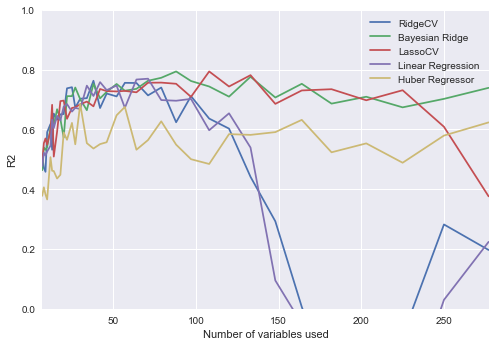

In [284]:
# Now plot it
results_df = pd.DataFrame(all_results, columns=names, index=number_of_coef)
results_df.plot()
plt.xlabel("Number of variables used")
plt.ylabel("R2")
plt.ylim(0,1)
plt.show()

Between 50 and 120 variables, all models perform pretty good
but Bayesian Ridge is the best at the following number of variables. The R2 is

In [285]:
results_df[results_df["Bayesian Ridge"] == results_df["Bayesian Ridge"].max()]

,RidgeCV,Bayesian Ridge,LassoCV,Linear Regression,Huber Regressor
88,0.623918,0.793903,0.752649,0.695925,0.54906


The previous plot shows how the different models works depending on how many variables we insert and thanks to this we can select the best number of features for our specific model.

Now we can perform the final model using only the previous number of variables on the original training set, and calculate the R^2 using the validation set:

In [286]:
best_number_of_variables = results_df[results_df["Bayesian Ridge"] == results_df["Bayesian Ridge"].max()].index[0]
X_training_best_coef = X_training[coefs_sorted.index[:best_number_of_variables]]
X_test_best_coef = X_final_test[coefs_sorted.index[:best_number_of_variables]]
tmp = linear_model.BayesianRidge()
tmp.fit(X_training_best_coef, y_training)
y_pred = tmp.predict(X_test_best_coef)

# And show the r2
print('R2 is equal to:')
r2_score(y_final_test, y_pred)

R2 is equal to:


0.73791745192365288

This R2 is quite high so thats a good result for our model. Finally we can see the predictions compared with the real data

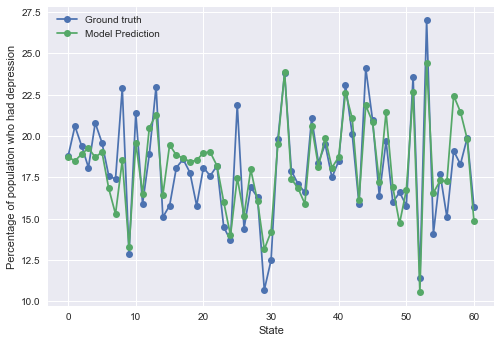

In [287]:
plt.plot(y_final_test, "o-")
plt.plot(y_pred, "o-")
plt.legend(["Ground truth", "Model Prediction"])
plt.xlabel("State")
plt.ylabel("Percentage of population who had depression")
plt.show()

### 2.2 - Add to your model census features at the US state level (e.g., income data) and discuss how adding them impacts the predictive performance of the model.

Since we made a different approach with respect to the questions and we created first a model with all the variables, we now try to create new models without some specific features and look at the difference of the results.

It is interesting to see that among all the optional features from the surveys that we inserted, just being foreign born it is automatically included in the model, but we will check in detail the difference made by these features adding the manually.

In [288]:
coefs_sorted.head(best_number_of_variables)[coefs_sorted.head(best_number_of_variables).index.str.contains("\(real")]

,Coef
Variable,
foreign born (real),-0.015668


We remove that feature and run the model again to see if there is a difference:

In [289]:
X_final_test_3 = X_test_best_coef[[c for c in X_test_best_coef.columns if "foreign born" not in c]]
X_training_3 = X_training_best_coef[[c for c in X_training_best_coef.columns if "foreign born" not in c]]

In [290]:
tmp_3 = linear_model.BayesianRidge()
tmp_3.fit(X_training_3,y_training)
y_pred_no_f = tmp_3.predict(X_final_test_3)

# And show the r2

r2_score(y_final_test, y_pred_no_f)

0.72956077672393904

As we can see, the model is a bit worse, 0.01 difference in R2 compared to the full one

###  2.3 - Look for data on health insurance coverage across US states (any source you can find) and integrate it in your model. Repeat the above evaluation.

Our model deprecated the health index because the coeficient was too low, but still we can add it back to check the preformance

In [291]:
X_reduced = X[coefs_sorted.head(best_number_of_variables).index]
X_reduced.shape

X_reduced['health (real)'] = X['health (real)'] 
X_final_test_3 = X_final_test_2[[c for c in X_final_test_2.columns if "foreign born" not in c]]

In [292]:
X_final_test_2 = X_reduced.iloc[indices_test]
X_training_2 = X_reduced.iloc[indices_train]

In [293]:
tmp_2 = linear_model.BayesianRidge()
tmp_2.fit(X_training_2,y_training)
y_pred_health = tmp_2.predict(X_final_test_2)

# And show the r2
r2_score(y_final_test, y_pred_health)

0.7377762477633657

The health insurance coverage across US states seems not relevant in this kind of prediction.